# Cargar los datos

In [52]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

In [104]:
url = "https://raw.githubusercontent.com/z3r0st/EB-2022-1-CC50/main/data/CAvideos_cc50_clean.csv"
parse_dates = ["trending_date", "publish_date", "publish_time"]
df = pd.read_csv(url, delimiter=',', parse_dates=parse_dates)

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40854 entries, 0 to 40853
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   video_id                40854 non-null  object        
 1   trending_date           40854 non-null  datetime64[ns]
 2   title                   40854 non-null  object        
 3   channel_title           40854 non-null  object        
 4   category_id             40854 non-null  float64       
 5   category_title          40854 non-null  object        
 6   publish_date            40854 non-null  datetime64[ns]
 7   tags                    40854 non-null  object        
 8   views                   40854 non-null  float64       
 9   likes                   40854 non-null  float64       
 10  dislikes                40854 non-null  float64       
 11  comment_count           40854 non-null  float64       
 12  thumbnail_link          40854 non-null  object

# Exploración

Para la exploración de los datos, nos interesa trabajar con las categorías, la cantidad de "vistas", "me gusta", "no me gusta", "comentarios" y el factor tiempo. Respecto al tiempo, se busca evaluar cómo ha evolucionado el volumen de videos de tendencia a lo largo del tiempo, por lo que nos interesa la fecha en la que el video ingresó a tendencias y no la fecha de publicación. A partir de ello, se filtrarán las columnas para tener un DataFrame que contenga únicamente los datos pertinentes para la exploración.

In [56]:
videos = df[["category_title", "views", "likes", "dislikes", "comment_count", "comments_disabled", "trending_date", "channel_title"]]

In [57]:
videos.head()

,category_title,views,likes,dislikes,comment_count,comments_disabled,trending_date,channel_title
0,Music,17158579.0,787425.0,43420.0,125882.0,False,2017-11-14,EminemVEVO
1,Comedy,1014651.0,127794.0,1688.0,13030.0,False,2017-11-14,iDubbbzTV
2,Comedy,3191434.0,146035.0,5339.0,8181.0,False,2017-11-14,Rudy Mancuso
3,Entertainment,2095828.0,132239.0,1989.0,17518.0,False,2017-11-14,nigahiga
4,Music,33523622.0,1634130.0,21082.0,85067.0,False,2017-11-14,Ed Sheeran


In [58]:
videos = videos.rename(columns={"category_title":"category"})

In [59]:
videos = videos.rename(columns={"comment_count":"comments"})

In [60]:
videos["category"].unique()

array(['Music', 'Comedy', 'Entertainment', 'News & Politics',
       'People & Blogs', 'Howto & Style', 'Film & Animation',
       'Science & Technology', 'Gaming', 'Sports',
       'Nonprofits & Activism', 'Pets & Animals', 'Travel & Events',
       'Autos & Vehicles', 'Education', 'Shows', 'Movies'], dtype=object)

Ahora se tiene un DataFrame limpio y con únicamente la información pertinente para el objetivo del estudio.

## Para visualización

In [ ]:
from plotly.subplots import make_subplots

In [ ]:
import plotly.graph_objects as go

In [ ]:
import plotly.express as px

In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # requires version >= 1.9.0

In [ ]:
import cufflinks as cf

In [ ]:
init_notebook_mode(connected=True)

#9/06/22
#Definir esta funcion para que las imagenes aparezcan y llamar dicha funcion en cada celda donde se ejecute una visualizacion
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:

# Para uso offline colocar
cf.go_offline()

# Exploración de los datos

## 1. ¿Qué categorías de videos son las de mayor tendencia?

### Si se sabe que todos los videos en el dataset han estado en tendencia en algún momento.

In [ ]:
videos[videos['trending_date'].isna()]

### Entonces para responder a esta pregunta se procederá a totalizar la cantidad de veces que una categoría ha estado en tendencia.

In [ ]:
timesInTrend = videos['category'].value_counts(sort = False)

In [ ]:
timesInTrend

In [ ]:
timesByCategory = pd.DataFrame({'category': timesInTrend.index, 'values': timesInTrend.values})

In [ ]:
configure_plotly_browser_state()

timesByCategory.iplot(kind = 'bar', 
                      x = 'category', 
                      y = 'values', 
                      xTitle = "Video Category Name", 
                      yTitle = "Times in trend", 
                      title = "Most Trending Video Categories", 
                      colors = "red")

### Para tener una visualización más clara, se procederá a acceder a las 6 categorías de mayor tendencia.

In [ ]:
timesInTrend = videos['category'].value_counts().head(6)

In [ ]:
timesInTrend

In [ ]:
timesByCategory = pd.DataFrame({'category': timesInTrend.index, 'values': timesInTrend.values})

### También se procederá a cambiar el gráfico de barras por un gráfico circular

In [ ]:
configure_plotly_browser_state()
fig = px.pie(timesByCategory,
             values = 'values',
             names = 'category',
             title = "Most Trending Video Categories")
fig.show()

En conclusión, se puede extraer del gráfico que dentro del grupo de categorías de videos con mayor tendencia, la categoría de 'Entertainment' es la que lidera por diferencia. Siguiéndole con una diferencia 9284 veces en tendencia, la categoría 'News & Politics'.

## 2. ¿Qué categorías de videos son los que más gustan?¿Y cuáles son las que menos gustan?

### Antes de iniciar con el filtrado, tacharemos del dataset aquellos registros donde no se hayan encontrado reacciones, tanto 'likes' como 'dislikes', puesto que la respuesta sería ambigua.

Para ello crearemos una nueva columna con la suma de los valores de likes con dislikes

In [ ]:
videos_ = videos[['likes','dislikes','category']]

In [ ]:
videos_['Reacciones'] = videos_['likes'] + videos_['dislikes']

In [ ]:
len(videos_[videos_['dislikes'] == 0][videos_['likes'] == 0])

In [ ]:
len(videos_[videos_['Reacciones'] != 0])

In [ ]:
len(videos_)

In [ ]:
if len(videos_) - len(videos_[videos_['Reacciones'] != 0]) == len(videos_[videos_['dislikes'] == 0][videos_['likes'] == 0]):
  print("Es correcta la distribución")

VWZR = "Videos WithReactions"

In [5]:
VWR = videos_[videos_['Reacciones'] != 0]

NameError: name 'videos_' is not defined

Ya teniendo el filtro necesario para obtener los videos con reacciones, procederemos a buscar la mejor forma de visualizar las categorías que más y menos gustan.

### Para responder a esta pregunta, se procederá a obtener la media de todos los valores agrupados por categoría. De esta manera, se tendrá claro la cantidad de 'likes' y 'dislikes' que recibe en promedio una categoría por video.

In [ ]:
ReactionsByCategory = VWR.groupby('category')[['likes', 'dislikes']].mean()

In [ ]:
ReactionsByCategory

In [ ]:
configure_plotly_browser_state()
ReactionsByCategory.iplot(kind = 'bar',
                          title = "Average Video Reactions by Category")

### Si bien el gráfico nos permite visualizar los dislikes y likes de manera indendiente, el hecho de que exista una gran diferencia entre las cantidades de reacciones, no nos permite visualizar de manera cómoda el orden de las categorías. Por ello, se procederá a cambiar de vista a uno por separado.

In [ ]:
getlikes = ReactionsByCategory['likes'].sort_values(ascending = False).head(6)

In [ ]:
getlikes

In [ ]:
getdislikes = ReactionsByCategory['dislikes'].sort_values(ascending = False).head(6)

In [ ]:
getdislikes

In [ ]:
def numFormated(cad):
  newCad = []
  for num in cad:
    newCad.append(format(num,'.2E'))
  return newCad

In [ ]:
configure_plotly_browser_state()
fig = make_subplots(
    rows = 1, 
    cols = 2,
    subplot_titles=("Likes grouped", "Dislikes grouped")
    )

fig.add_trace(
    go.Bar(name='likes', 
           x = getlikes.index, 
           y = getlikes.values,
           text = numFormated(getlikes.values),
           textposition='auto'),
    row = 1, col = 1
    )
fig.add_trace(
    go.Bar(name='dislikes',
           x = getdislikes.index, 
           y = getdislikes.values,
           text = numFormated(getdislikes.values),
           textposition='auto'),
    row = 1, col = 2
    )

fig.update_xaxes(title_text="Category", row=1, col=1)
fig.update_xaxes(title_text="Category", row=1, col=2)

fig.update_yaxes(title_text="Mean of likes", row=1, col=1)
fig.update_yaxes(title_text="Mean of dislikes",row=1, col=2)

fig.update_layout(title = "Average Video Reactions by Category")
fig.show()

### Como se puede apreciar en la gráfica, la categoría de videos que más gustan, son las de 'Music' y 'Nonprofits & Activism' con promedios 151 753 y 146 323 de likes por video, respectivamente, mientras que las que menos gustan, lidera la categoría 'Nonprofits & Activism' con un promedio de 33 225.8 dislikes por video.

## 3. ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Me gusta” / “No me gusta”?

Primero, se revisan los datos recolectados del dataset organizado

In [ ]:
videos.head()

Comprobamos el número de categorias existentes

In [ ]:
videos["category"].nunique()

Luego, calculamos la media de likes y dislikes por categoria

In [ ]:
likes=videos.groupby('category')['likes'].mean()
dislikes=videos.groupby('category')['dislikes'].mean()

In [ ]:
likes.head()

In [ ]:
dislikes.head()

Con esta información, calculamos el ratio de "Me gusta"(likes) y "No me gusta"(dislikes) y se examinan los **5 mejores**

In [ ]:
ratio_videos_reactions=pd.DataFrame([likes,dislikes])

In [ ]:
ratio_videos_reactions=ratio_videos_reactions.transpose()

In [ ]:
ratio_videos_reactions['ratio']=(ratio_videos_reactions['likes']/ratio_videos_reactions['dislikes'])

In [ ]:
ratio_videos_reactions.sort_values(by=['ratio'], ascending=True)

In [ ]:
best_ratio_reactions=ratio_videos_reactions.sort_values(by=['ratio'], ascending=False).head()

In [ ]:
best_ratio_reactions

### Data Visualization

In [ ]:
import plotly.express as px

Usando un gráfico de barras apiladas podemos observar las 5 categorías con mejor ratio entre "Me gusta" y "No me gusta"

In [ ]:
best_ratio_reactions[['likes','dislikes']].plot(kind='bar', stacked=True)
plt.title("Ratio Likes/Dislikes")

De igual manera, habiendo convertido el index a una columna con las categorías, se crea un gráfico interactivo para una mejor visualización de las diferencias de ratio entre categorías.

In [ ]:
ratio_videos_reactions= ratio_videos_reactions.reset_index()

In [ ]:
fig = px.scatter(ratio_videos_reactions,x='likes', y='dislikes',color='category')
fig.show(renderer='colab')

##  4. ¿Qué categorías de videos tienen la mejor proporción (ratio) de “Vistas” / “Comentarios”?

In [61]:
videos["category"].nunique()

17

Partiendo de un **total de 17 categorías**, nos interesa obtener el **top 5** de categorías según este ratio.

### Primer método de exploración
Lo primero que se realizará es obtener directamente el top 5 de categorías, para ello se creará un nuevo DataFrame, agrupado por categoría y que tenga como atributos las vistas y comentarios, que serán los promedios de vistas y comentarios para la categoría.

In [62]:
videos_engagement_per_cat = pd.DataFrame([videos.groupby("category")["views"].mean(), videos.groupby("category")["comments"].mean()])

In [63]:
videos_engagement_per_cat.head()

category,Autos & Vehicles,Comedy,Education,Entertainment,Film & Animation,Gaming,Howto & Style,Movies,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Shows,Sports,Travel & Events
views,567784.284091,982248.076637,536602.767911,1.016742e+06,1.425656e+06,923759.215030,781356.949651,2.853415e+06,3.531199e+06,388220.736475,1.562184e+06,786733.562272,638461.173442,1.233845e+06,577012.161290,1.075964e+06,366701.408163
comments,2886.295455,5199.301777,2995.374369,4.113932e+03,4.854655e+03,7191.136161,4158.057827,2.329833e+03,1.405173e+04,2226.445780,4.354785e+04,4098.667073,4941.837398,6.241748e+03,622.927419,2.749927e+03,1556.002551


In [64]:
videos_engagement_per_cat = videos_engagement_per_cat.transpose()

In [65]:
videos_engagement_per_cat.head()

,views,comments
category,,
Autos & Vehicles,5.677843e+05,2886.295455
Comedy,9.822481e+05,5199.301777
Education,5.366028e+05,2995.374369
Entertainment,1.016742e+06,4113.932009
Film & Animation,1.425656e+06,4854.655442


Al DataFrame se el añade el atributo ratio, para poder ordenarlo según el objetivo de esta exploración.

In [66]:
videos_engagement_per_cat["ratio"] = videos_engagement_per_cat["views"]/videos_engagement_per_cat["comments"]

In [67]:
videos_engagement_per_cat.sort_values(by=["ratio"], ascending=False).head()

,views,comments,ratio
category,,,
Movies,2.853415e+06,2329.833333,1224.729237
Shows,5.770122e+05,622.927419,926.291159
Sports,1.075964e+06,2749.927136,391.269860
Film & Animation,1.425656e+06,4854.655442,293.667764
Music,3.531199e+06,14051.734048,251.299859


Se tiene así el top 5 según el ratio vistas/comentarios, con la información de la cantidad de vistas y comentarios y el valor exacto del ratio.

### Gráfico de barras apilado

<AxesSubplot:xlabel='category'>

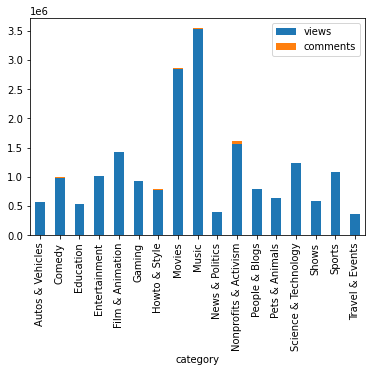

In [68]:
videos_engagement_per_cat.drop("ratio", axis=1).plot.bar(stacked=True)

Es difícil distinguir la magnitud de la cantidad de comentarios, se probará a continuación solo para el top 5.

<AxesSubplot:xlabel='category'>

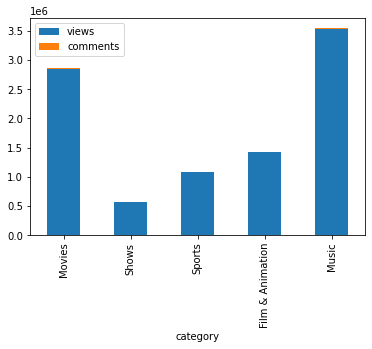

In [69]:
videos_engagement_per_cat.sort_values(by=["ratio"], ascending=False).head().drop("ratio", axis=1).plot.bar(stacked=True)

Si bien un gráfico de barras apilado sería ideal para un análisis de ratio, en este caso particular, la diferencia de magnitud entre las vistas y los comentarios es tan grande que no resulta una buena herramienta, por lo que se pasará a generar un gráfico de dispersión (scatterplot).

### Seaborn
Primero se graficará la distribución de todas las categorías, tomando en el eje de las abcisas el valor de la cantidad de comentarios promedio y en el eje de las ordenadas el valor de la cantidad de vistas promedio. Se toman los promedios para reducir la dispersión de los resultados, manteniendo la integridad de los mismos.

In [71]:
import seaborn as sns

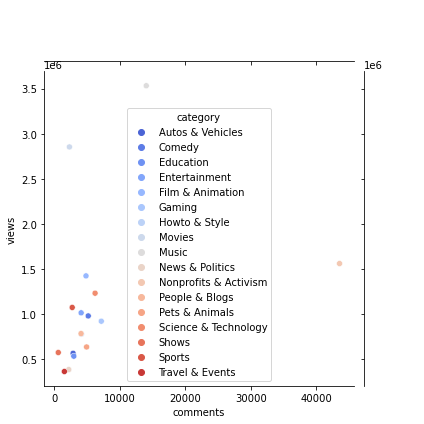

In [72]:
sns.jointplot(x="comments", y="views", data=videos_engagement_per_cat, hue="category", palette="coolwarm")

Al realizarlo con la librería seaborn, se presentó un problema con el posicionamiento de la leyenda, por lo cual se prefirió realizarlo de manera más manual y personalizada con matplotlib.

### Matplotlib

In [74]:
import matplotlib.pyplot as plt

In [76]:
views = videos.groupby("category")["views"].mean()
comments = videos[videos["comments_disabled"] == False].groupby("category")["comments"].mean()

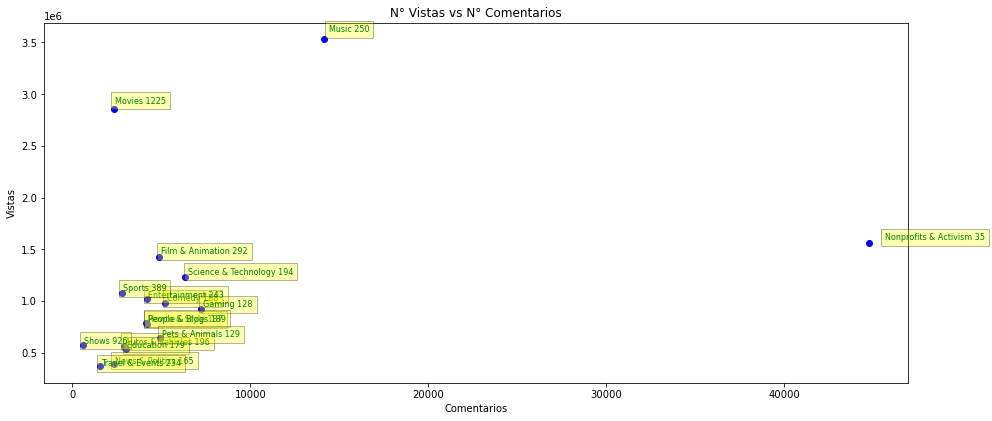

In [77]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0, 0, 1, 1])
ax1.scatter(comments, views, color="blue")
ax1.set_xlabel("Comentarios")
ax1.set_ylabel("Vistas")
ax1.set_title("N° Vistas vs N° Comentarios")

for cat in comments.index:
    plt.text(x=comments.loc[cat]*1.02, y=views.loc[cat]*1.02, s=f"{cat} {views.loc[cat]/comments.loc[cat]:.0f}",
    fontdict=dict(color='green', size=8), bbox=dict(facecolor='yellow',alpha=0.3))

La gráfica no muestra los resultados con la suficiente claridad, debido al estiramiento en el eje x producido por la categoría "Nonprofits & Activism". Sin embargo, podemos distinguir fácilmente que esta categoría es la que cuenta con el peor ratio vistas/comentarios, por lo que la podemos excluir de la visualización.

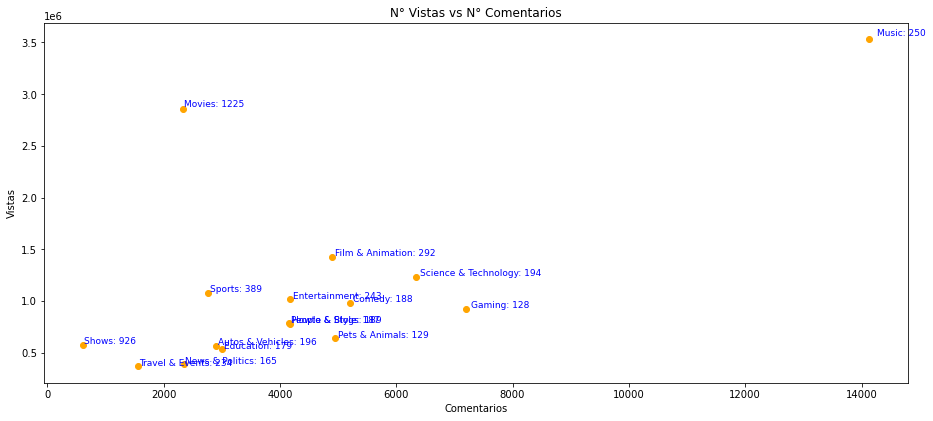

In [78]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0, 0, 1, 1])
ax1.scatter(comments.drop("Nonprofits & Activism"), views.drop("Nonprofits & Activism"), color="orange")
ax1.set_xlabel("Comentarios")
ax1.set_ylabel("Vistas")
ax1.set_title("N° Vistas vs N° Comentarios")

for cat in comments.drop("Nonprofits & Activism").index:
    plt.text(x=comments.loc[cat]*1.01, y=views.loc[cat]*1.01, 
             s=f"{cat}: {views.loc[cat]/comments.loc[cat]:.0f}",
             fontdict=dict(color='blue', size=9))

Esta visualización nos provee de mayor claridad en la visualización, pero no la suficiente. Sin embargo, es posible ya identificar el top 5 de categorías según el ratio vistas/comentarios:
1. Movies: 1225 vistas por comentario
2. Shows: 926 vistas por comentario
3. Sports: 389 vistas por comentario
4. Film & Animation: 292 vistas por comentario
5. Music: 250 vistas por comentario

Para poder apreciar mejor la distribución de las categorías con valores cercanos, se graficará sin la categoría Music.

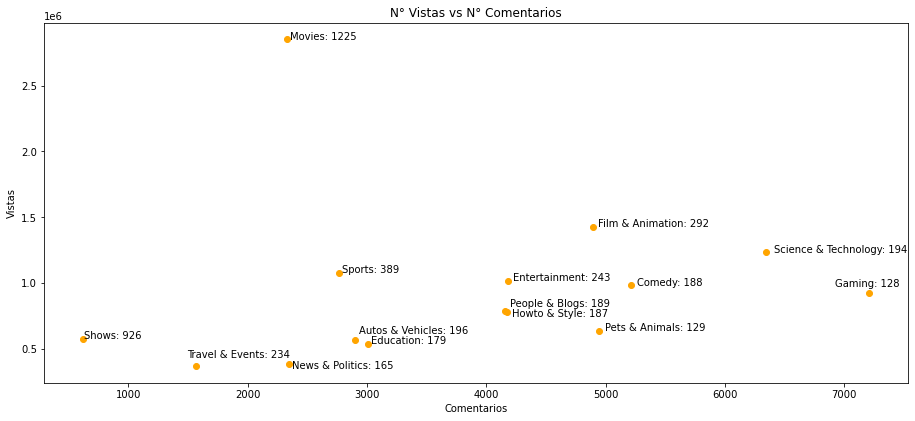

In [79]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0, 0, 1, 1])
ax1.scatter(comments.drop(["Nonprofits & Activism", "Music"]), views.drop(["Nonprofits & Activism", "Music"]), color="orange")
ax1.set_xlabel("Comentarios")
ax1.set_ylabel("Vistas")
ax1.set_title("N° Vistas vs N° Comentarios")

for cat in comments.drop(["Nonprofits & Activism", "Music"]).index:
    xmod = 1.01
    ymod = 1
    if cat == "Autos & Vehicles": ymod += 0.08
    elif cat == "News & Politics": ymod -= 0.1
    elif cat == "Travel & Events": 
        ymod += 0.18 
        xmod -= 0.06
    elif cat == "People & Blogs": ymod += 0.04
    elif cat == "Howto & Style": ymod -= 0.05
    elif cat == "Gaming": 
        xmod -= 0.05
        ymod += 0.05
    plt.text(x=comments.loc[cat]*xmod, y=views.loc[cat]*ymod,
             s=f"{cat}: {views.loc[cat]/comments.loc[cat]:.0f}",
             fontdict=dict(color='black', size=10))

A partir de este proceso, se ha visualizado gráficamente los ratios vistas/comentarios de todas las categorías y confirmado el top 5 obtenido al inicio.

## 5. ¿Cómo ha cambiado el volumen de los videos en tendencia a lo largo del tiempo?

Primero, resulta necesario identificar el rango de fechas que comprende el dataset, para determinar la unidad temporal sobre la cual se partirá la data.

In [80]:
videos.sort_values(by="trending_date", ascending=False).head()

,category,views,likes,dislikes,comments,comments_disabled,trending_date,channel_title
40853,Entertainment,107392.0,300.0,62.0,251.0,False,2018-06-14,我愛小明星大跟班
40716,Entertainment,3854712.0,524135.0,14650.0,55735.0,False,2018-06-14,BB Ki Vines
40726,News & Politics,88173.0,937.0,41.0,299.0,False,2018-06-14,The View
40725,Film & Animation,93447.0,760.0,27.0,167.0,False,2018-06-14,优优独播剧场——YoYo Television Series Exclusive
40724,Howto & Style,358052.0,21199.0,338.0,3239.0,False,2018-06-14,All Things Adrienne


In [81]:
videos.sort_values(by="trending_date").head()

,category,views,likes,dislikes,comments,comments_disabled,trending_date,channel_title
0,Music,17158579.0,787425.0,43420.0,125882.0,False,2017-11-14,EminemVEVO
127,Pets & Animals,152118.0,9642.0,129.0,6095.0,False,2017-11-14,AntsCanada
128,News & Politics,72253.0,1217.0,146.0,569.0,False,2017-11-14,The View
129,News & Politics,100394.0,1619.0,907.0,1595.0,False,2017-11-14,The Young Turks
130,People & Blogs,30001.0,221.0,7.0,101.0,False,2017-11-14,News Center


Se concluye que el dataset contiene los videos en tendencia entre noviembre de 2017 y junio de 2018. Por ello, se considera oportuno realizar una división por mes, teniendo un total de 8 meses.

In [82]:
trending_videos_volume_over_time = videos[["category", "trending_date"]]

In [83]:
import datetime

In [84]:
trending_videos_volume_over_time["trending_date"].head()

0    2017-11-14
1    2017-11-14
2    2017-11-14
3    2017-11-14
4    2017-11-14
Name: trending_date, dtype: object

Se crea una nueva columna que almacena el mes en el cual el video estuvo en tendencias, y otra que almacena el año.

In [88]:
trending_videos_volume_over_time.loc[:,"trending_month"] = [m%12 + 1 for m in trending_videos_volume_over_time["trending_date"].values.astype("datetime64[M]").astype(int)]

In [86]:
trending_videos_volume_over_time.loc[:,"trending_year"] = [y + 1970 for y in trending_videos_volume_over_time["trending_date"].values.astype("datetime64[Y]").astype(int)]

In [89]:
trending_videos_volume_over_time.sort_values(by="trending_date", ascending=False).head()

,category,trending_date,trending_month,trending_year
40853,Entertainment,2018-06-14,6,2018
40716,Entertainment,2018-06-14,6,2018
40726,News & Politics,2018-06-14,6,2018
40725,Film & Animation,2018-06-14,6,2018
40724,Howto & Style,2018-06-14,6,2018


In [90]:
trending_videos_volume_over_time.groupby(["trending_year", "trending_month"]).count()

category  trending_date
trending_year trending_month                         
2017          11                  3398           3398
              12                  6193           6193
2018          1                   5780           5780
              2                   5550           5550
              3                   6186           6186
              4                   4787           4787
              5                   6160           6160
              6                   2800           2800

Se comprueba que el total de videos al sumar los subtotales por mes sea igual al total de videos del dataset limpio original (videos).

In [91]:
assert sum(trending_videos_volume_over_time.groupby(["trending_year", "trending_month"])["trending_date"].count()) == len(videos)

In [92]:
trending_videos_volume_per_month = trending_videos_volume_over_time.rename(columns={"trending_year":"Año", "trending_month":"Mes"}).groupby(["Año", "Mes"])["trending_date"].count()

In [93]:
trending_videos_volume_per_month

Año   Mes
2017  11     3398
      12     6193
2018  1      5780
      2      5550
      3      6186
      4      4787
      5      6160
      6      2800
Name: trending_date, dtype: int64

In [94]:
indeces = trending_videos_volume_over_time.rename(columns={"trending_year":"Año", "trending_month":"Mes"}).groupby(["Año", "Mes"])["trending_date"].count().index

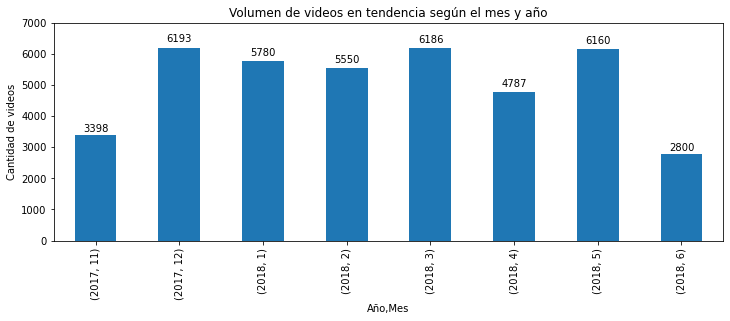

In [95]:
plt.figure(figsize=(12,4))
trending_videos_volume_per_month.plot.bar()
plt.ylabel("Cantidad de videos")
plt.title("Volumen de videos en tendencia según el mes y año")
plt.ylim([0, 7000])
plt.style.use('ggplot')
plt.rcParams["axes.grid.axis"] ="y"
plt.rcParams["axes.grid"] = True
for i in range(len(indeces)):
    plt.text(x=i-0.15, y=trending_videos_volume_per_month.iloc[i]*1.03, s=trending_videos_volume_per_month.iloc[i])

Se determina que la tendencia no siguió una tendencia positiva ni negativa en el intervalo temporal comprendido en el dataset. Se puede afirmar que el mayor volumen de tendencia se presenta en Diciembre, seguido de cerca por Marzo y Mayo. Por otra parte, el volumen más bajo se registra en los meses de noviembre y junio.

### Considerando muestra

In [96]:
trending_videos_volume_over_time.head()

,category,trending_date,trending_month,trending_year
0,Music,2017-11-14,11,2017
1,Comedy,2017-11-14,11,2017
2,Comedy,2017-11-14,11,2017
3,Entertainment,2017-11-14,11,2017
4,Music,2017-11-14,11,2017


In [97]:
trending_videos_volume_over_time.sort_values(by="trending_date", ascending=False).head()

,category,trending_date,trending_month,trending_year
40853,Entertainment,2018-06-14,6,2018
40716,Entertainment,2018-06-14,6,2018
40726,News & Politics,2018-06-14,6,2018
40725,Film & Animation,2018-06-14,6,2018
40724,Howto & Style,2018-06-14,6,2018


En las dos tablas previas se puede visualizar que la recopilación de datos para el mes inicial (noviembre 2017) y para el mes final (junio 2018), no están completas. Se recopiló los datos solo hasta la mitad del mes. Por ello, el volumen de videos es notoriamente menor en ambos meses. Debido a que se recopiló en ambos casos una cantidad de días que equivale aproximadamente a la mitad del mes, se duplicarán ambos valores.

In [98]:
edited_trending_videos_volume_per_month = trending_videos_volume_per_month
edited_trending_videos_volume_per_month.iloc[0] *= 2
edited_trending_videos_volume_per_month.iloc[7] *= 2

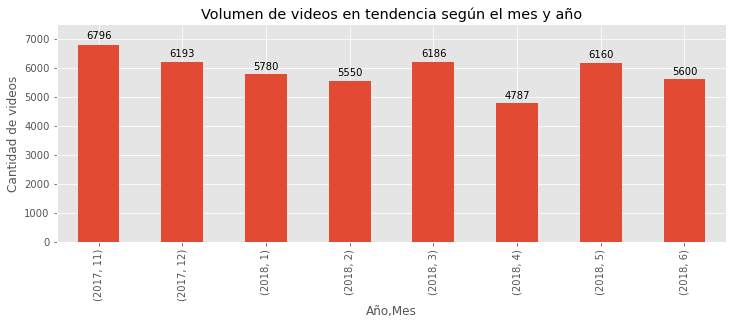

In [99]:
plt.figure(figsize=(12,4))
edited_trending_videos_volume_per_month.plot.bar()
plt.ylabel("Cantidad de videos")
plt.title("Volumen de videos en tendencia según el mes y año")
plt.ylim([0, 7500])
plt.style.use('ggplot')
plt.rcParams["axes.grid.axis"] ="y"
plt.rcParams["axes.grid"] = True
for i in range(len(indeces)):
    plt.text(x=i-0.15, y=trending_videos_volume_per_month.iloc[i]*1.03, s=trending_videos_volume_per_month.iloc[i])

Con las modificaciones, sigue sin presentarse una tendencia clara con el paso del tiempo, pero se identifica a noviembre como mes con mayor volumen y a abril con el mes con menor volumen. Esto se verá de forma más clara en la siguiente tabla:

In [100]:
edited_trending_videos_volume_per_month.sort_values(ascending=False)

Año   Mes
2017  11     6796
      12     6193
2018  3      6186
      5      6160
      1      5780
      6      5600
      2      5550
      4      4787
Name: trending_date, dtype: int64

## 6. ¿Qué canales de Youtube son tendencia más frecuentemente?¿Y cuáles con menos tendencia?

In [12]:
videos.info()

NameError: name 'videos' is not defined

### Para el desarrollo de esta pregunta necesitaremos saber con exactitud el mes y el año, para medir la frecuencia en que un canal aparece en tendencias por mes.

In [ ]:
trendingChannels = videos[['channel_title','trending_date']]

In [ ]:
trendingChannels['trending_year']  = trendingChannels['trending_date'].dt.year
trendingChannels['trending_month'] = trendingChannels['trending_date'].dt.month

In [ ]:
trendingChannels = trendingChannels[['trending_year', 'trending_month','channel_title']].astype(str)

In [ ]:
trendingChannels['yearMonth'] = trendingChannels['trending_year'] + "-" + trendingChannels['trending_month']

In [ ]:
trendingChannels

In [ ]:
artificio = trendingChannels.groupby('yearMonth').count()

In [13]:
artificio.index

NameError: name 'artificio' is not defined

In [ ]:
len(artificio.index)

In [ ]:
artificio.index[0]

In [ ]:
tempDF = trendingChannels[trendingChannels['yearMonth'] == '2017-11'].groupby('channel_title').count()['yearMonth'].head()

In [ ]:
tempDF.index

In [ ]:
titles = tuple(artificio.index)

In [ ]:
titles

In [14]:
configure_plotly_browser_state()

fig = make_subplots(
    rows = 2,
    cols = 4,
    subplot_titles = titles
)

filas = 1
columnas = 1
for index in artificio.index:
  tempDF = trendingChannels[trendingChannels['yearMonth'] == index].groupby('channel_title').count()['yearMonth'].sort_values(ascending = False).head(10)
  
  fig.add_trace(
      go.Bar(name= index,
           x = tempDF.index, 
           y = tempDF.values,),
      row = filas, col = columnas
  )
  columnas+=1
  if(columnas > 4):
    filas += 1
    columnas = 1

filas = 1
columnas = 1
for index in artificio.index: 
  fig.update_xaxes(title_text = "Channel Title", row = filas, col = columnas)
  fig.update_yaxes(title_text = "Number of videos in trending", row = filas, col = columnas)
  columnas+=1
  if(columnas > 4):
    filas += 1
    columnas = 1

fig.update_layout(height = 1000, title = 'Channels with the highest frequency of being in the Top Trending')
fig.show()

NameError: name 'configure_plotly_browser_state' is not defined

### Del gráfico  podemos darnos cuenta que los canales 'CNN', 'REACT' y 'VikatanTV' son los que más frecuentemente [de mediados de noviembre del 2017 a mediados de junio del 2018] tienden a presentar videos que son catalogados como tendencia. O en otras palabras, son aquellos canales que son tendencia más frecuentemente.

In [ ]:
configure_plotly_browser_state()

fig = make_subplots(
    rows = 2,
    cols = 4,
    subplot_titles = titles
)

filas = 1
columnas = 1
for index in artificio.index:
  tempDF = trendingChannels[trendingChannels['yearMonth'] == index].groupby('channel_title').count()['yearMonth'].sort_values().head(10)
  
  fig.add_trace(
      go.Bar(name= index,
           x = tempDF.index, 
           y = tempDF.values,),
      row = filas, col = columnas
  )
  columnas+=1
  if(columnas > 4):
    filas += 1
    columnas = 1

filas = 1
columnas = 1
for index in artificio.index: 
  fig.update_xaxes(title_text = "Channel Title", row = filas, col = columnas)
  fig.update_yaxes(title_text = "Number of videos in trending", row = filas, col = columnas)
  columnas+=1
  if(columnas > 4):
    filas += 1
    columnas = 1

fig.update_layout(height = 1000, title = 'Top 6 Channels with less frequency of being in the Top Trending')
fig.show()

### A diferencia del más frecuente, en este caso -de los menos frecuentes-, no se presenta una tendencia clara de un canal en específico para catalogarlo como el "menos frecuente" en tendencias. Sin embargo, se podría totalizar de manera absoluta el dataset, y realizar un conteo de los canales que estén presentes en el conjunto de datos y acceder a los que tengan el menor contador. Si bien esto podría ser una solución, se perdería la escencia de "frecuencia" porque estaríamos validando una frecuencia que abarca el 100% de margen de tiempo del dataset.

## 7. ¿En qué Estados se presenta el mayor número de “Vistas”, “Me gusta” y “No me gusta”? 

Importamos las librerias necesarias

In [ ]:
import plotly.express as px

### Se deben separar las provincias así que se crea un nuevo DataFrame con las características solicitadas

In [ ]:
coordinates1=df.groupby('state')['lat'].unique()

In [ ]:
coordinates2=df.groupby('state')['lon'].unique()

In [ ]:
viewsByState=df.groupby('state')['views'].mean()

In [15]:
likesByState=df.groupby('state')['likes'].mean()

In [16]:
dislikesByState=df.groupby('state')['dislikes'].mean()

In [17]:
topStates=pd.DataFrame([coordinates1,coordinates2,viewsByState,likesByState,dislikesByState]).transpose()

NameError: name 'coordinates1' is not defined

Convertimos los datos tipo objeto a float

In [ ]:
topStates = topStates.astype({'lat':'float','lon':'float'})

### Evaluamos el **top 5** con cada característica

#### Mayor cantidad de "Vistas"

In [ ]:
topStates.sort_values('views',ascending=False)

Podemos concluir que el top 5 de provincias con más "Vistas" es:


*   Nova Scotia
*   British Columbia
*   Alberta
*   Northwest Territories
*   Prince Edward Island

#### Mayor cantidad de "Me gusta"

In [ ]:
topStates.sort_values('likes',ascending=False)

Podemos concluir que el top 5 de provincias con más "Me gusta" es:


*   British Columbia
*   Northwest Territories
*   Nova Scotia
*   Alberta
*   Ontario

#### Mayor cantidad de "No me gusta"

In [ ]:
topStates.sort_values('dislikes',ascending=False)

Podemos concluir que el top 5 de provincias con más "No me gusta" es:


*   Alberta
*   Nova Scotia
*   Saskatchewan
*   Prince Edward Island
*   Northwest Territories

### Data Visualization

Para poder realizar las gráficas convertimos los datos float a int y reseteamos el index para obtener la columna de provincias (state)

In [ ]:
topStates_ = topStates.astype({'views':'int','likes':'int','dislikes':'int'})

In [ ]:
topStates_=topStates_.reset_index()

In [ ]:
topStates_

#### Mayor cantidad de vistas

In [ ]:
fig=px.scatter_geo(topStates_,lat='lat',lon='lon',
                  color='views',
                   size='views',
                   hover_name='state',
                   hover_data=['views','likes','dislikes'],
                  scope='north america')
fig.update_layout(title='Provincias de Canada según su número de "Vistas"')
fig.show(renderer="colab")

Evaluamos el mapa/gráfico con la conclusión anterior y podemos confirmar el top 5. Teniendo como primer lugar a la provincia de Nova Scotia.

#### Mayor cantidad de "Me gusta"

In [ ]:
fig=px.scatter_geo(topStates_,lat='lat',lon='lon',
                  color='likes',
                   size='likes',
                   hover_name='state',
                   hover_data=['views','likes','dislikes'],
                  scope='north america')
fig.update_layout(title='Provincias de Canada con mayor número de "Me gustas"')
fig.show(renderer="colab")

Evaluamos el mapa/gráfico con la conclusión anterior y podemos confirmar el top 5. Teniendo como primer lugar a la provincia de British Columbia.

#### Mayor cantidad de "No me gustas"

In [18]:
fig=px.scatter_geo(topStates_,lat='lat',lon='lon',
                  color='dislikes',
                   size='dislikes',
                   hover_name='state',
                   hover_data=['views','likes','dislikes'],
                  scope='north america')
fig.update_layout(title='Provincias de Canada con mayor número de "No me gustas"')
fig.show(renderer="colab")

NameError: name 'px' is not defined

Evaluamos el mapa/gráfico con la conclusión anterior y podemos confirmar el top 5. Teniendo como primer lugar a la provincia de Alberta.